In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans33.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans36.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans30.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans29.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans31.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans32.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans37.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans39.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans38.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans49.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans48.png
/kaggle/input/avengers-faces-dataset/images/val/chris_evans/chris_evans35.png
/kaggle/input/avengers-faces-dataset/images/val/mark_ruffalo/mar

In [3]:
import tensorflow as tf
import os

print("--- Step 1: Setting up Paths and Loading Data ---")

# --- Setup Paths ---
base_dir = '/kaggle/input/avengers-faces-dataset/images'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

# --- Image Settings ---
IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 32

# --- Load Data into a TPU-Optimized Format ---
# This is the modern, efficient way to load image data.
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE,
  label_mode='categorical'
)

# --- Get Class Info and Optimize the Datasets ---
class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# This is a critical optimization for performance on TPUs.
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("\nStep 1 Complete! Data is ready.")

--- Step 1: Setting up Paths and Loading Data ---
Found 274 files belonging to 5 classes.


I0000 00:00:1754472210.331390      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 60 files belonging to 5 classes.
Found 5 classes: ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']

Step 1 Complete! Data is ready.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomBrightness
)

print("--- Step 2: Building the Upgraded Model Architecture ---")

# Define the data augmentation layers to make the model more robust
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2)
  ],
  name="data_augmentation",
)

# Define the model architecture
model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

print("\nStep 2 Complete! Model has been built.")
model.summary()

--- Step 2: Building the Upgraded Model Architecture ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Step 2 Complete! Model has been built.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    21,234,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,329,989 (81.37 MB)

 Trainable params: 21,329,989 (81.37 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import os
import collections

print("--- The Definitive Training Script: Preventing Mode Collapse ---")

# --- 1. SETUP & DATA LOADING ---
base_dir = '/kaggle/input/avengers-faces-dataset/images'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

IMG_HEIGHT = 160
IMG_WIDTH = 160
BATCH_SIZE = 32

# Load data
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, label_mode='categorical'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_dir, image_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, label_mode='categorical'
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Found {num_classes} classes: {class_names}")

# Sanity Check: Count images per class in the training set
class_counts = collections.Counter(label for _, labels in train_ds.unbatch() for label in [tf.argmax(labels).numpy()])
print("Image counts per class in training set:")
for i, class_name in enumerate(class_names):
    print(f"- {class_name}: {class_counts[i]}")


# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


# --- 2. BUILD THE ROBUST TRANSFER LEARNING MODEL ---
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
base_model.trainable = False # Start with the base model frozen

inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base_model(x, training=False)
x = Flatten()(x)

# --- THE KEY IMPROVEMENT: ADDING BATCH NORMALIZATION ---
# This layer stabilizes the inputs to the Dense layers, which is crucial for preventing collapse.
x = BatchNormalization()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)


# --- 3. COMPILE AND TRAIN WITH ADVANCED CALLBACKS ---
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- THE SECOND KEY IMPROVEMENT: LEARNING RATE SCHEDULING ---
# This callback will automatically reduce the learning rate if the model stops improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# We also use EarlyStopping to prevent wasting time on a failing run.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# And ModelCheckpoint to save the best version.
save_path = "/kaggle/working/avengers_final_best_model.keras"
checkpoint = ModelCheckpoint(save_path, save_best_only=True, monitor='val_accuracy', mode='max')

print("\nStarting final, robust training run...")
EPOCHS = 30 # Give it enough time to learn and for the callbacks to work.
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, reduce_lr, early_stopping]
)

print(f"\nTraining complete. The best model was saved to {save_path}")

--- The Definitive Training Script: Preventing Mode Collapse ---
Found 274 files belonging to 5 classes.
Found 60 files belonging to 5 classes.
Found 5 classes: ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']
Image counts per class in training set:
- chris_evans: 50
- chris_hemsworth: 53
- mark_ruffalo: 66
- robert_downey_jr: 51
- scarlett_johansson: 54

Starting final, robust training run...
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5112 - loss: 2.0105 - val_accuracy: 0.8667 - val_loss: 1.4938 - learning_rate: 0.0010
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9720 - loss: 0.2599 - val_accuracy: 0.8833 - val_loss: 1.2699 - learning_rate: 0.0010
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9851 - loss: 0.0731 - val_accuracy: 0.8833 - val_loss: 0.5022 - learning_rate: 0.0010
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9938 - loss: 0.0399 - val_accuracy: 0.9167 - val

--- Final Testing: Using the Definitive Model ---
Loading best model from: /kaggle/working/avengers_final_best_model.keras
The model is trained on these classes: ['chris_evans', 'chris_hemsworth', 'mark_ruffalo', 'robert_downey_jr', 'scarlett_johansson']

Randomly selecting 5 images to test...

--- Testing image: mark_ruffalo62.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
True Label:      mark_ruffalo
Predicted Label: chris_evans (100.00%)


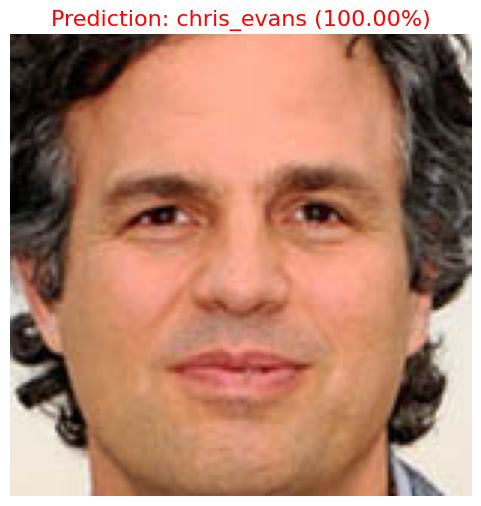


--- Testing image: chris_evans33.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
True Label:      chris_evans
Predicted Label: chris_evans (100.00%)


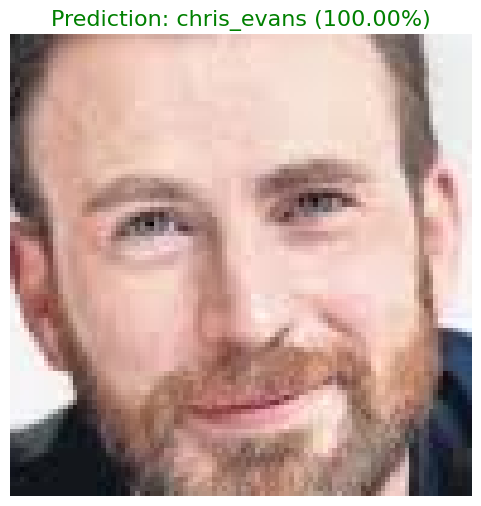


--- Testing image: mark_ruffalo60.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
True Label:      mark_ruffalo
Predicted Label: chris_evans (100.00%)


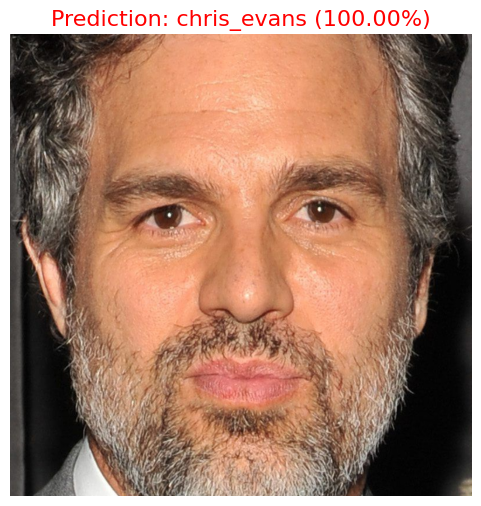


--- Testing image: chris_evans32.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
True Label:      chris_evans
Predicted Label: chris_evans (100.00%)


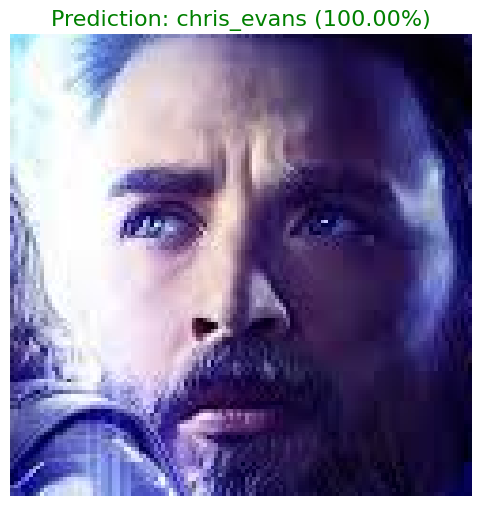


--- Testing image: scarlett_johansson31.png ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
True Label:      scarlett_johansson
Predicted Label: chris_evans (100.00%)


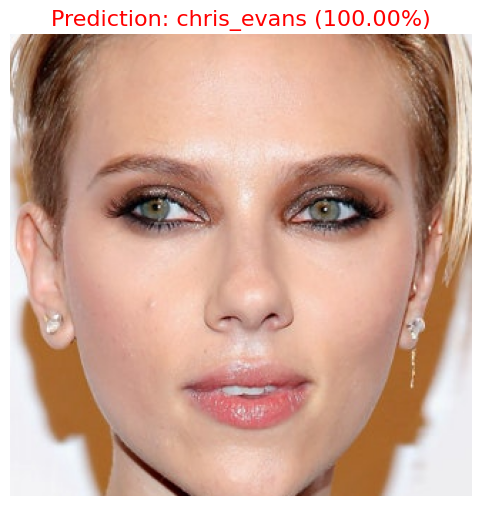


--- Project Complete! ---


In [16]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

print("--- Final Testing: Using the Definitive Model ---")

# --- 1. LOAD YOUR BEST MODEL ---
# Make sure this path points to the model you just saved
model_path = '/kaggle/working/avengers_final_best_model.keras'
print(f"Loading best model from: {model_path}")
model = tf.keras.models.load_model(model_path)

# Get the class names from the training directory folders
train_dir = '/kaggle/input/avengers-faces-dataset/images/train'
class_names = sorted(os.listdir(train_dir))
print(f"The model is trained on these classes: {class_names}")


# --- 2. FIND AND SELECT RANDOM TEST IMAGES ---
test_dir = '/kaggle/input/avengers-faces-dataset/images/test'
all_test_image_paths = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_test_image_paths.append(os.path.join(root, file))

num_images_to_test = 5 # Test 5 random images
if len(all_test_image_paths) < num_images_to_test:
    num_images_to_test = len(all_test_image_paths)

random_test_images = random.sample(all_test_image_paths, num_images_to_test)
print(f"\nRandomly selecting {num_images_to_test} images to test...")


# --- 3. LOOP THROUGH IMAGES, PREDICT, AND DISPLAY ---
for image_path in random_test_images:
    print(f"\n--- Testing image: {os.path.basename(image_path)} ---")
    
    # Load the image
    image = cv2.imread(image_path)
    
    # Preprocess the image for the MobileNetV2 model
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image_rgb, (160, 160))
    image_batch = np.expand_dims(image_resized, axis=0)
    preprocessed_image = tf.keras.applications.mobilenet_v2.preprocess_input(image_batch)

    # --- 4. MAKE A PREDICTION ---
    predictions = model.predict(preprocessed_image)
    predicted_index = np.argmax(predictions[0])
    predicted_person = class_names[predicted_index]
    confidence = np.max(predictions[0]) * 100
    
    # --- 5. DISPLAY THE RESULT ---
    # Find the true label from the file path for comparison
    true_person = os.path.basename(os.path.dirname(image_path))
    
    print(f"True Label:      {true_person}")
    print(f"Predicted Label: {predicted_person} ({confidence:.2f}%)")
    
    # Set title color to green for correct predictions, red for incorrect
    title_color = 'green' if true_person == predicted_person else 'red'
    
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {predicted_person} ({confidence:.2f}%)", color=title_color, fontsize=16)
    plt.xlabel(f"True Label: {true_person}", fontsize=12)
    plt.axis('off')
    plt.show()

print("\n--- Project Complete! ---")